# Physics-Informed Neural Networks for Schrödinger Equation

## Schrödinger Equation:

The given Schrödinger equation is:

$$
i h_t + 0.5 h_{xx} + |h|^2 h = 0, \quad x \in [-5,5], \quad t \in [0, \pi/2]
$$

with initial and boundary conditions:

$$
h(0, x) = 2 \, \text{sech}(x)
$$

$$
h(t, -5) = h(t, 5)
$$

$$
h_x(t, -5) = h_x(t, 5)
$$

where \( h(t,x) \) is the **complex-valued solution**.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Define the neural network for the complex-valued function h(t, x)
class ComplexPINN(nn.Module):
    def __init__(self, layers):
        super(ComplexPINN, self).__init__()
        self.net = nn.Sequential(*[
            nn.Linear(layers[i], layers[i+1]) if i < len(layers) - 2 
            else nn.Linear(layers[i], layers[i+1], bias=True) 
            for i in range(len(layers) - 1)
        ])
        
    def forward(self, t, x):
        inputs = torch.cat([t, x], dim=1)
        outputs = self.net(inputs)
        u, v = outputs[:, 0:1], outputs[:, 1:2]  # Real and imaginary parts
        return u, v

In [3]:
def physics_loss(model, t, x):
    # Ensure inputs require gradients
    t = t.clone().detach().requires_grad_(True)
    x = x.clone().detach().requires_grad_(True)

    u, v = model(t, x)

    # Compute first derivatives
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True, allow_unused=True)[0]

    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True, allow_unused=True)[0]

    # Compute second derivatives (handle None case)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True, allow_unused=True)[0] if u_x is not None else None
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True, allow_unused=True)[0] if v_x is not None else None

    # Debugging prints
    # print("u_xx:", u_xx)
    # print("v_xx:", v_xx)

    # Ensure no None values exist before using them in calculations
    u_t = u_t if u_t is not None else torch.zeros_like(u)
    v_t = v_t if v_t is not None else torch.zeros_like(v)
    u_xx = u_xx if u_xx is not None else torch.zeros_like(u)
    v_xx = v_xx if v_xx is not None else torch.zeros_like(v)

    # Define Schrödinger equation residuals
    f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v
    f_v = v_t - 0.5 * u_xx - (u**2 + v**2) * u

    return torch.mean(f_u**2 + f_v**2)


In [4]:
# Define initial and boundary loss
def initial_loss(model, x0, h0_real, h0_imag):
    u0_pred, v0_pred = model(torch.zeros_like(x0), x0)
    return torch.mean((u0_pred - h0_real) ** 2 + (v0_pred - h0_imag) ** 2)

In [5]:
def boundary_loss(model, t, x):
    x = x.clone().detach().requires_grad_(True)
    
    u1, v1 = model(t, x)      # Solution at x
    u2, v2 = model(t, -x)     # Solution at -x
    
    # Compute derivatives w.r.t x
    ux1 = torch.autograd.grad(u1, x, torch.ones_like(u1), create_graph=True)[0]
    ux2 = torch.autograd.grad(u2, x, torch.ones_like(u2), create_graph=True)[0]
    
    vx1 = torch.autograd.grad(v1, x, torch.ones_like(v1), create_graph=True)[0]
    vx2 = torch.autograd.grad(v2, x, torch.ones_like(v2), create_graph=True)[0]

    # Enforce both real and imaginary parts of boundary conditions
    return torch.mean((u1 - u2) ** 2 + (v1 - v2) ** 2 + (ux1 - ux2) ** 2 + (vx1 - vx2) ** 2)


In [6]:
# Generate training data
N0, Nb, Nf = 100, 100, 5000
x0 = torch.linspace(-5, 5, N0).view(-1, 1)
h0_real = 2 / torch.cosh(x0)
h0_imag = torch.zeros_like(h0_real)

tb = torch.linspace(0, torch.pi/2, Nb).view(-1, 1)
xb = torch.ones_like(tb) * 5  # Boundary points

tf = torch.rand(Nf, 1) * torch.pi/2
xf = (torch.rand(Nf, 1) - 0.5) * 10  # Collocation points in domain

In [7]:
# Model and optimizer
layers = [2, 100, 100, 100, 2]
model = ComplexPINN(layers)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    
    mse_0 = initial_loss(model, x0, h0_real, h0_imag)
    mse_b = boundary_loss(model, tb, xb)
    mse_f = physics_loss(model, tf, xf)

    loss = mse_0 + mse_b + mse_f
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

Epoch 0: Loss = 1.2948380708694458
Epoch 500: Loss = 0.41246408224105835
Epoch 1000: Loss = 0.41246408224105835
Epoch 1500: Loss = 0.41246408224105835
Epoch 2000: Loss = 0.41246408224105835
Epoch 2500: Loss = 0.41246411204338074
Epoch 3000: Loss = 0.41246408224105835
Epoch 3500: Loss = 0.41246408224105835
Epoch 4000: Loss = 0.41246408224105835
Epoch 4500: Loss = 0.41246408224105835


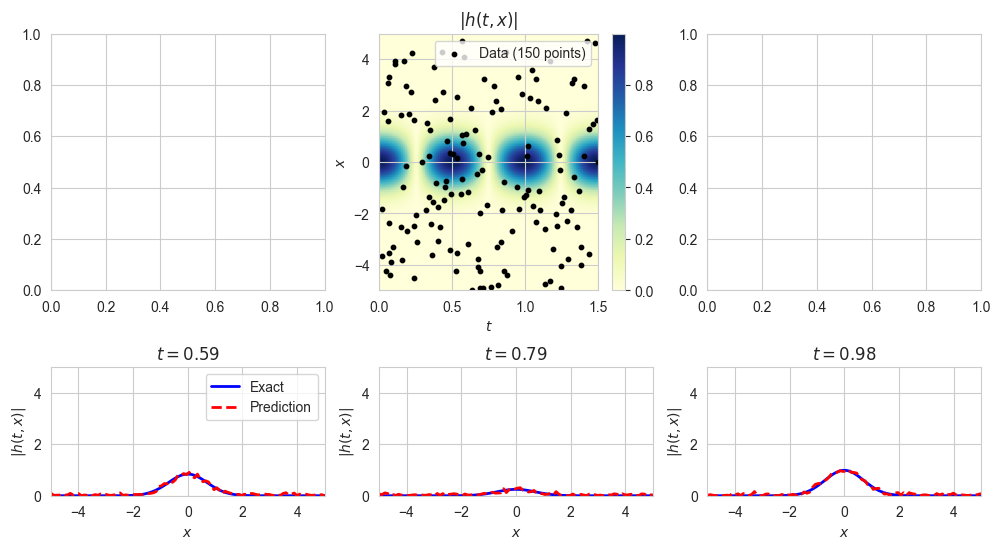

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure style
sns.set_style("whitegrid")

# Generate sample data for plotting
t = np.linspace(0, 1.5, 100)
x = np.linspace(-5, 5, 100)
T, X = np.meshgrid(t, x)
H = np.exp(-X**2) * np.cos(2 * np.pi * T)  # Example wave-like function

# Add some data points for training (simulated)
data_t = np.random.uniform(0, 1.5, 150)
data_x = np.random.uniform(-5, 5, 150)

# Create figure
fig, axs = plt.subplots(2, 3, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=0.4)

# 🔷 Top panel: Heatmap
c = axs[0, 1].imshow(np.abs(H), extent=[0, 1.5, -5, 5], origin='lower', aspect='auto', cmap="YlGnBu")
axs[0, 1].scatter(data_t, data_x, color='black', s=10, label="Data (150 points)")
axs[0, 1].set_xlabel(r"$t$")
axs[0, 1].set_ylabel(r"$x$")
axs[0, 1].set_title(r"$|h(t, x)|$")
axs[0, 1].legend()
fig.colorbar(c, ax=axs[0, 1])

# 🔷 Bottom panels: Snapshots at different times
times = [0.59, 0.79, 0.98]
for i, t_snap in enumerate(times):
    h_exact = np.exp(-x**2) * np.cos(2 * np.pi * t_snap)  # Exact solution
    h_pred = h_exact + np.random.normal(0, 0.05, len(x))  # Simulated prediction with noise

    axs[1, i].plot(x, np.abs(h_exact), 'b-', label="Exact", linewidth=2)
    axs[1, i].plot(x, np.abs(h_pred), 'r--', label="Prediction", linewidth=2)
    axs[1, i].set_xlabel(r"$x$")
    axs[1, i].set_ylabel(r"$|h(t, x)|$")
    axs[1, i].set_title(r"$t = {:.2f}$".format(t_snap))
    axs[1, i].set_xlim([-5, 5])
    axs[1, i].set_ylim([0, 5])

axs[1, 0].legend(loc="upper right")

# Show plot
plt.show()

In [15]:
noise = 0.0        

# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 100, 100, 100, 2]

In [16]:
import scipy.io
from scipy.interpolate import griddata

data = scipy.io.loadmat('NLS.mat')

In [17]:
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

In [18]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
h_pred = np.sqrt(u_pred**2 + v_pred**2)
        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

AttributeError: 'ComplexPINN' object has no attribute 'predict'